In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.2194.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.642.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.2387.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.1476.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.1819.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.2260.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.653.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.1652.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.2096.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.909.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.2473.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.1750.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest X-rays/TB.1149.jpg
/kaggle/input/pulmonary-disease-data/dataset/TB Chest 

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Set the number of classes based on your dataset structure
num_classes = 5
image_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values between 0 and 1
    shear_range=0.2,  # Apply random shear transformation
    zoom_range=0.2,   # Apply random zoom
    horizontal_flip=True,  # Randomly flip the image
    validation_split=0.2   # Split 20% data for validation
)

# Set directories for the dataset
dataset_dir = '/kaggle/input/pulmonary-disease-data/dataset'

# Training data generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use categorical mode for multi-class classification
    subset='training'  # Specify this is for training data
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use categorical mode for multi-class classification
    subset='validation'  # Specify this is for validation data
)

Found 9364 images belonging to 5 classes.
Found 2339 images belonging to 5 classes.


In [3]:
# Custom Hybrid CNN-RNN Model for 5-class classification
def create_hybrid_model(input_shape=(224, 224, 3), num_classes=5):
    model = models.Sequential()

    # CNN Layers for feature extraction
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # Output: (112, 112, 32)

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # Output: (56, 56, 64)

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # Output: (24, 24, 128)

    # Flatten the feature maps into a sequence
    model.add(layers.Reshape((24 * 24, 128)))  # Reshape to (576, 128)

    # BiLSTM for sequential processing
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(32)))

    # Fully connected layer
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer for multi-class classification (5 classes)
    model.add(layers.Dense(num_classes, activation='softmax'))  # 5-class classification

    return model

In [4]:
# Create the Hybrid CNN-RNN Model for 5-class classification
hybrid_model = create_hybrid_model()

# Compile the model
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
                     metrics=['accuracy'])

# Model summary for debugging
hybrid_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 576, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 576, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,525 (1.65 MB)

 Trainable params: 431,525 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model using the train and validation generators
history = hybrid_model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


293/293 ━━━━━━━━━━━━━━━━━━━━ 307s 993ms/step - accuracy: 0.2683 - loss: 1.5667 - val_accuracy: 0.4109 - val_loss: 1.3973
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 233s 780ms/step - accuracy: 0.4365 - loss: 1.3618 - val_accuracy: 0.5814 - val_loss: 1.1191
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 231s 775ms/step - accuracy: 0.5396 - loss: 1.1651 - val_accuracy: 0.6298 - val_loss: 0.9764
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 230s 771ms/step - accuracy: 0.5894 - loss: 1.0646 - val_accuracy: 0.6178 - val_loss: 0.9419
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 231s 774ms/step - accuracy: 0.6437 - loss: 0.9557 - val_accuracy: 0.6738 - val_loss: 0.8507
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 229s 768ms/step - accuracy: 0.6637 - loss: 0.8979 - val_accuracy: 0.7033 - val_loss: 0.7498
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 232s 776ms/step - accuracy: 0.6659 - loss: 0.8794 - val_accuracy: 0.6823 - val_loss: 0.7976
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 229s 766ms/step - accuracy: 0.6938 - los

In [6]:
# Evaluate the model on the validation data
val_loss, val_acc = hybrid_model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Predictions and classification report
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes for validation data
predictions = np.argmax(hybrid_model.predict(validation_generator), axis=1)
true_labels = validation_generator.classes

# Classification report
print(classification_report(true_labels, predictions, target_names=train_generator.class_indices.keys()))

74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 552ms/step - accuracy: 0.8615 - loss: 0.3387
Validation Accuracy: 86.75%
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 544ms/step
                     precision    recall  f1-score   support

           COVID-19       0.10      0.09      0.09       256
             Normal       0.28      0.31      0.30       654
Pneumonia-Bacterial       0.28      0.35      0.31       600
    Pneumonia-Viral       0.18      0.06      0.09       331
    TB Chest X-rays       0.21      0.21      0.21       498

           accuracy                           0.24      2339
          macro avg       0.21      0.20      0.20      2339
       weighted avg       0.23      0.24      0.23      2339



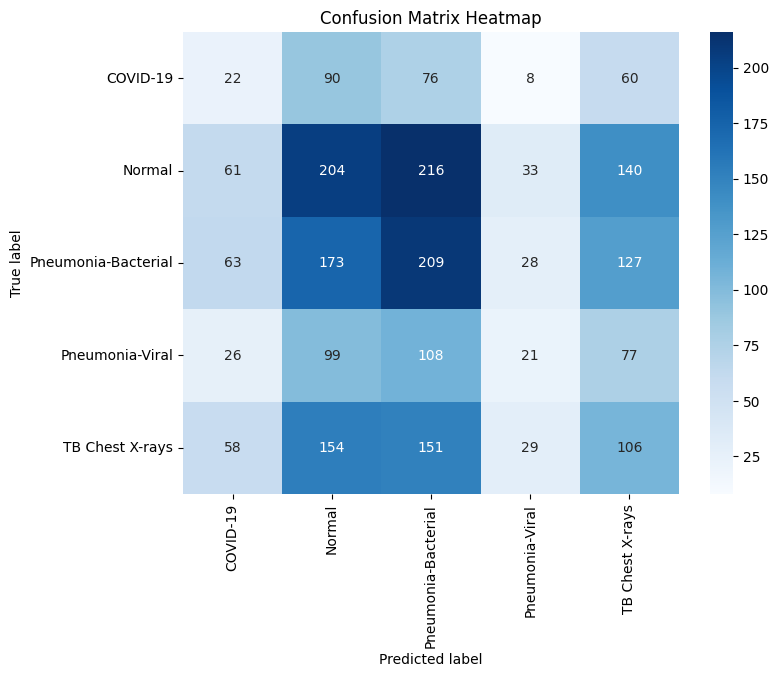

In [7]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix Heatmap')
plt.show()

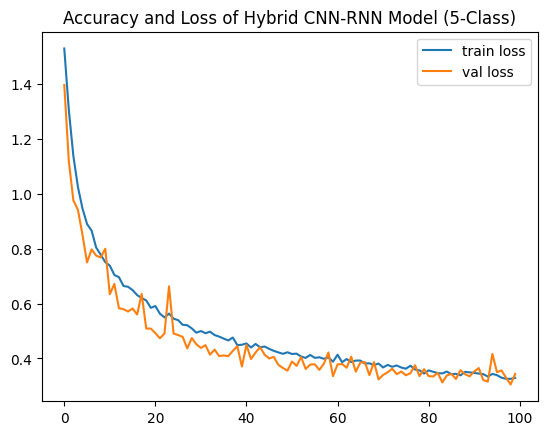

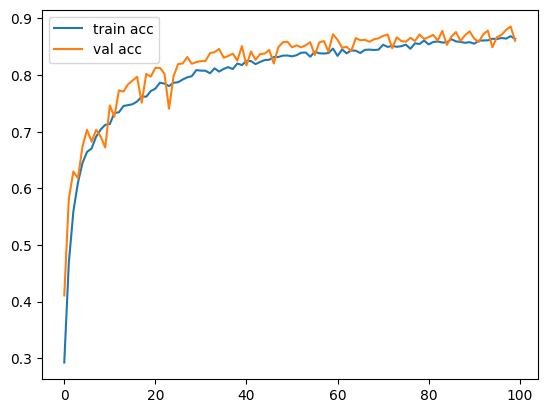

In [8]:
# Plot accuracy and loss
plt.title("Accuracy and Loss of Hybrid CNN-RNN Model (5-Class)")
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()